# Training Final Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from datetime import datetime

import os
import yaml
import sys

sys.path.append('../src')
import utils.utils as utils

!pip freeze > ../requirements.txt

d:\huynq1\202507-homecredit-pd\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_set = pd.read_csv('../data/cleaned_train_data.csv')
test_set = pd.read_csv('../data/cleaned_test_data.csv')

X_train = train_set.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train_set.TARGET
X_test = test_set.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_test = test_set.TARGET

# Double check categorical cols
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' or X_train[col].dtype == 'category']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

## Model training with optimized params

### Train model

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=810)

models = []

with open('../configs/model_config.yaml', 'r') as file:
    params = yaml.safe_load(file)

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 810

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Training Fold {fold+1}")
    X_train_kf, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_kf, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    train_data = lightgbm.Dataset(X_train_kf, label=y_train_kf, categorical_feature=cat_cols)
    val_data = lightgbm.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lightgbm.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000,
        callbacks=[
            lightgbm.early_stopping(stopping_rounds=50),
        ]
    )
    models.append(model)

Training Fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[851]	training's auc: 0.867293	valid_1's auc: 0.774376
Training Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[936]	training's auc: 0.871597	valid_1's auc: 0.775216
Training Fold 3
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	training's auc: 0.8771	valid_1's auc: 0.776762
Training Fold 4
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	training's auc: 0.877073	valid_1's auc: 0.77114
Training Fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[832]	training's auc: 0.864302	valid_1's auc: 0.76759


### Calculate ROC AUC and GINI for ensembled model

In [20]:
preds = np.zeros(len(X_test))
# Calculate and print the ROC AUC
for model in models:
    preds += model.predict(X_test) / len(models)
roc_auc = roc_auc_score(y_test, preds)

# Calculate GINI
gini = 2 * roc_auc - 1
print(f"ROC AUC: {roc_auc}")
print(f"GINI: {gini}")

ROC AUC: 0.7779534976791839
GINI: 0.5559069953583677


In [11]:
# Get the current datetime
current_datetime = datetime.now().strftime('%y-%m-%d_%H-%M-%S')

for i, model in enumerate(models):
    model.save_model(f'../models/{current_datetime}_lgbm_fold_{i+1}.txt')

## Validating Model

In [21]:
cm = confusion_matrix(y_test, preds.round())
cm

array([[56441,    96],
       [ 4805,   160]])

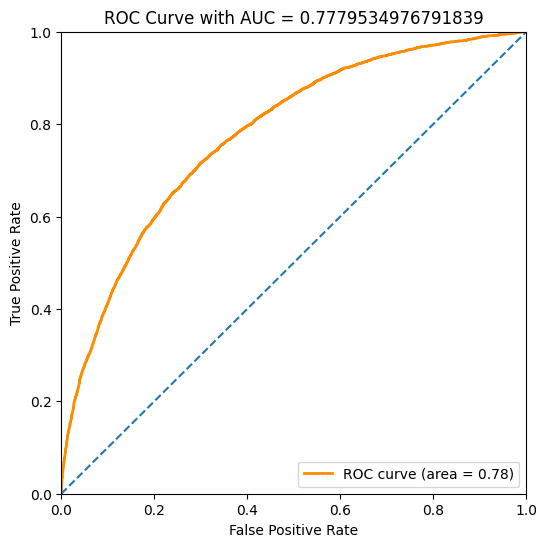

In [22]:
fpr, tpr, thres = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='-', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve with AUC = {}'.format(roc_auc))

_plot_roc_curve(fpr, tpr, roc_auc)

In [23]:
current_datetime = datetime.now().strftime('%y-%m-%d_%H-%M-%S')
# Export y_test and preds to csv
y_test_preds = pd.DataFrame({'y_test': y_test, 'preds': preds})
y_test_preds.to_csv(f'../log/preds/{current_datetime}_predictions.csv', index=False)

## Predict on Submit Set

In [27]:
submit_data = pd.read_csv('../data/cleaned_submit_data.csv')
submit = submit_data.drop(['SK_ID_CURR'], axis=1)
for col in cat_cols:
    submit[col] = submit[col].astype('category')

In [31]:
preds_submits = np.zeros(len(submit))

for model in models:
    preds_submits += model.predict(submit) / len(models)

# Create new test output with SK_ID_CURR on X set and [preds_submits]
submit_output = pd.DataFrame({'SK_ID_CURR': submit_data['SK_ID_CURR'], 'TARGET': preds_submits})
# Get the current datetime
current_datetime = datetime.now().strftime('%y-%m-%d_%H-%M-%S')
# Save the DataFrame to a CSV file with the generated filename
submit_output.to_csv(f'../log/submits/{current_datetime}_submission.csv', index=False)